<a href="https://colab.research.google.com/github/aidanqadi/P1/blob/main/Project1_NonMajors_Analysis_Fixed_executed_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 Analysis: Non-Majors Computing Survey

**Name:** Aidan Qadi  
**Date:** August 1, 2025

This notebook loads the raw survey CSV, performs cleaning with documented decisions, and answers four key questions to support CCM IT recruitment/messaging:
1. Motivations for enrolling and their variation by age/gender  
2. Most effective sources of information  
3. Relationship between information source and interest in further computing classes  
4. Computing class interests by race/ethnicity

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io

# Prompt user to upload the CSV file
uploaded = files.upload()

# Get the filename from the uploaded dictionary (assuming only one file is uploaded)
filename = list(uploaded.keys())[0]

# Load raw data
df_raw = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

# Initial exploration
print("Original shape:", df_raw.shape)
display(df_raw.head(3))

# List relevant column groups before cleaning
motivation_cols_orig = [c for c in df_raw.columns if 'What motivated you to seek a computing class at CCM?' in c]
interest_type_cols_orig = [c for c in df_raw.columns if 'which ones interest you most?' in c.lower()]
overall_interest_col_orig = [c for c in df_raw.columns if 'scale of 1 to 5' in c.lower()]
source_cols_orig = [c for c in df_raw.columns if 'Did you receive information about our computing course from any of the following sources?' in c]
demographic_cols_orig = ['Gender', 'Race/ethnicity', 'Age ']

print("\nMotivation columns (original) and unique values:")
for c in motivation_cols_orig:
    print(f"  {c}: {pd.unique(df_raw[c])}")

print("\nInterest type columns (original) and sample unique values:")
for c in interest_type_cols_orig:
    print(f"  {c}: {pd.unique(df_raw[c])[:5]}")

print("\nOverall interest column (original):", overall_interest_col_orig)
if overall_interest_col_orig:
    print(df_raw[overall_interest_col_orig[0]].value_counts())

print("\nSource columns (original) and sample values:")
for c in source_cols_orig:
    print(f"  {c}: {pd.unique(df_raw[c])[:5]}")

print("\nDemographics value counts:")
for d in demographic_cols_orig:
    if d in df_raw.columns:
        print(f"  {d}:")
        print(df_raw[d].value_counts(dropna=False))

Saving NonMajorSurvey.csv to NonMajorSurvey (1).csv
Original shape: (92, 71)


,Timestamp,Which course are you currently enrolled in?,What motivated you to seek a computing class at CCM? [It’s a required class for the degree I’m seeking],What motivated you to seek a computing class at CCM? [To keep current in computing skills],What motivated you to seek a computing class at CCM? [Career Advancement],What motivated you to seek a computing class at CCM? [Career Change],What motivated you to seek a computing class at CCM? [Professional Development],What motivated you to seek a computing class at CCM? [Job Displacement],What motivated you to seek a computing class at CCM? [Relocation],What motivated you to seek a computing class at CCM? [IT Industry Certifications],...,"If you answered that you were interested in taking more computing classes, which ones interest you most? [CyberSecurity]","If you answered that you were interested in taking more computing classes, which ones interest you most? [App Development]","If you answered that you were interested in taking more computing classes, which ones interest you most? [Data Analytics]","If you answered that you were interested in taking more computing classes, which ones interest you most? [Machine Learning/Artificial Intelligence]","If you answered that you were interested in taking more computing classes, which ones interest you most? [Computer Programming]","If you answered that you were interested in taking more computing classes, which ones interest you most? [Game Design]","If you answered that you were interested in taking more computing classes, which ones interest you most? [Hardware Installation & Repair]",Gender,Race/ethnicity,Age
0,2024/09/10 10:47:35 AM AST,CMP 126 Computer Technology and Applications,No,Yes,Yes,Yes,Yes,No,No,No,...,Yes,No,No,No,No,No,No,Prefer not to say,Hispanic or Latino;Black/African American;Whit...,19-20
1,2024/09/10 11:00:05 AM AST,CMP 126 Computer Technology and Applications,Yes,Yes,Yes,No,Yes,Yes,No,No,...,Yes,Yes,Yes,Yes,Yes,No,No,Woman,Hispanic or Latino,19-20
2,2024/09/10 11:02:51 AM AST,CMP 126 Computer Technology and Applications,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,...,No,Yes,No,Yes,Yes,Yes,Yes,Man,Choose not to reply,18 and younger



Motivation columns (original) and unique values:
  What motivated you to seek a computing class at CCM? [It’s a required class for the degree I’m seeking]: ['No' 'Yes']
  What motivated you to seek a computing class at CCM? [To keep current in computing skills]: ['Yes' 'No']
  What motivated you to seek a computing class at CCM? [Career Advancement]: ['Yes' 'No']
  What motivated you to seek a computing class at CCM? [Career Change]: ['Yes' 'No']
  What motivated you to seek a computing class at CCM? [Professional Development]: ['Yes' 'No']
  What motivated you to seek a computing class at CCM? [Job Displacement]: ['No' 'Yes']
  What motivated you to seek a computing class at CCM? [Relocation]: ['No' 'Yes']
  What motivated you to seek a computing class at CCM? [IT Industry Certifications]: ['No' 'Yes']
  What motivated you to seek a computing class at CCM? [Financial]: ['Yes' 'No']
  What motivated you to seek a computing class at CCM? [Personal Enrichment]: ['Yes' 'No']
  What motiv

## Data Cleaning

**Decisions documented:**  
- Column names are standardized to snake_case, stripped of punctuation for ease of typing.  
- Checkbox-style responses ('Yes'/'No' and "Don't recall") are mapped to binary indicators; "Don't recall" is treated as 0 (lack of confirmed exposure).  
- The overall interest score is converted to numeric.  
- Demographic text fields are stripped of whitespace.

In [6]:
# Work on a copy
df = df_raw.copy()

# Function to clean column names
def clean_col(c):
    c = c.strip()
    c = c.lower()
    for ch in ['/', '&', '?', '%', ',', '.', '(', ')', '[', ']', "'", '’', '"', ':', '...']:
        c = c.replace(ch, '')
    c = c.replace('  ', ' ')
    c = c.replace(' ', '_')
    # collapse repeated underscores
    while '__' in c:
        c = c.replace('__','_')
    c = c.strip('_')
    return c

df.columns = [clean_col(c) for c in df.columns]

# Shorten key columns
# Motivation columns automatically detected
motivation_cols = [c for c in df.columns if c.startswith('what_motivated_you_to_seek_a_computing_class_at_ccm')]
# Map to shorter names
shorten = {
    motivation_cols[0]: 'mot_required_degree' if len(motivation_cols) > 0 else None,
    motivation_cols[1]: 'mot_keep_skills' if len(motivation_cols) > 1 else None,
    motivation_cols[2]: 'mot_career_advancement' if len(motivation_cols) > 2 else None,
    motivation_cols[3]: 'mot_career_change' if len(motivation_cols) > 3 else None,
    motivation_cols[4]: 'mot_prof_development' if len(motivation_cols) > 4 else None,
    motivation_cols[5]: 'mot_job_displacement' if len(motivation_cols) > 5 else None,
    motivation_cols[6]: 'mot_relocation' if len(motivation_cols) > 6 else None,
    motivation_cols[7]: 'mot_certifications' if len(motivation_cols) > 7 else None,
    motivation_cols[8]: 'mot_financial' if len(motivation_cols) > 8 else None,
    motivation_cols[9]: 'mot_personal_enrichment' if len(motivation_cols) > 9 else None,
    motivation_cols[10]: 'mot_curiosity' if len(motivation_cols) > 10 else None,
}
# Filter out None
shorten = {k:v for k,v in shorten.items() if k and v}
df = df.rename(columns=shorten)

# Overall interest column detection and rename
interest_cols_candidates = [c for c in df.columns if c.startswith('on_a_scale_of_1_to_5')]
if interest_cols_candidates:
    df = df.rename(columns={interest_cols_candidates[0]: 'interest_overall'})

# Interest type columns shorten
int_map = {}
for col in df.columns:
    if col.startswith('if_you_answered_that_you_were_interested_in_taking_more_computing_classes_which_ones_interest_you_most'):
        if 'web_development' in col:
            int_map[col] = 'int_web_dev'
        elif 'cybersecurity' in col:
            int_map[col] = 'int_cybersecurity'
        elif 'app_development' in col:
            int_map[col] = 'int_app_dev'
        elif 'data_analytics' in col:
            int_map[col] = 'int_data_analytics'
        elif 'machine_learningartificial_intelligence' in col:
            int_map[col] = 'int_ml_ai'
        elif 'computer_programming' in col:
            int_map[col] = 'int_programming'
        elif 'game_design' in col:
            int_map[col] = 'int_game_design'
        elif 'hardware_installation_repair' in col:
            int_map[col] = 'int_hardware_repair'
df = df.rename(columns=int_map)

# Shorten source columns
src_rename = {}
for col in df.columns:
    if col.startswith('did_you_receive_information_about_our_computing_course_from_any_of_the_following_sources'):
        if 'high_school_guidance_counselor' in col:
            src_rename[col] = 'src_high_school_counselor'
        elif 'ccm_information_technologies_website' in col:
            src_rename[col] = 'src_ccm_it_website'
        elif 'ccm_admissions' in col:
            src_rename[col] = 'src_ccm_admissions'
        elif 'ccm_advisorcounselor' in col:
            src_rename[col] = 'src_ccm_advisor_counselor'
        elif 'employer' in col:
            src_rename[col] = 'src_employer'
        elif 'other' in col:
            src_rename[col] = 'src_other'
df = df.rename(columns=src_rename)

# Demographics fix
if 'raceethnicity' in df.columns:
    df = df.rename(columns={'raceethnicity':'race_ethnicity'})
if 'age_' in df.columns:
    df = df.rename(columns={'age_':'age'})  # in case trailing underscore

# Convert checkbox-style to numeric
yes_no_map = {'Yes':1, 'No':0, "Don't recall":0, "dont recall":0, "Dont recall":0}
for col in df.columns:
    if col.startswith('mot_') or col.startswith('int_') or col.startswith('src_'):
        df[col] = df[col].map(yes_no_map).fillna(0).astype(int)

# Convert interest_overall to numeric
df['interest_overall'] = pd.to_numeric(df.get('interest_overall', pd.Series()), errors='coerce')

# Clean demographic text
for col in ['gender','race_ethnicity','age']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()

print("Post-cleaning columns:", df.columns.tolist())
print("Sample of cleaned data:")
display(df.head(3))

Post-cleaning columns: ['timestamp', 'which_course_are_you_currently_enrolled_in', 'mot_required_degree', 'mot_keep_skills', 'mot_career_advancement', 'mot_career_change', 'mot_prof_development', 'mot_job_displacement', 'mot_relocation', 'mot_certifications', 'mot_financial', 'mot_personal_enrichment', 'mot_curiosity', 'prior_to_applying_to_college_did_you_participate_in_any_of_the_following_events_or_activities_at_the_county_college_of_morris_andor_with_the_department_of_information_technologies_if_at_all_open_house', 'prior_to_applying_to_college_did_you_participate_in_any_of_the_following_events_or_activities_at_the_county_college_of_morris_andor_with_the_department_of_information_technologies_if_at_all_instant_decision_day', 'prior_to_applying_to_college_did_you_participate_in_any_of_the_following_events_or_activities_at_the_county_college_of_morris_andor_with_the_department_of_information_technologies_if_at_all_on-campus_information_session', 'prior_to_applying_to_college_did_you_

,timestamp,which_course_are_you_currently_enrolled_in,mot_required_degree,mot_keep_skills,mot_career_advancement,mot_career_change,mot_prof_development,mot_job_displacement,mot_relocation,mot_certifications,...,int_cybersecurity,int_app_dev,int_data_analytics,int_ml_ai,int_programming,int_game_design,int_hardware_repair,gender,race_ethnicity,age
0,2024/09/10 10:47:35 AM AST,CMP 126 Computer Technology and Applications,0,1,1,1,1,0,0,0,...,1,0,0,0,0,0,0,Prefer not to say,Hispanic or Latino;Black/African American;Whit...,19-20
1,2024/09/10 11:00:05 AM AST,CMP 126 Computer Technology and Applications,1,1,1,0,1,1,0,0,...,1,1,1,1,1,0,0,Woman,Hispanic or Latino,19-20
2,2024/09/10 11:02:51 AM AST,CMP 126 Computer Technology and Applications,1,1,1,1,1,1,1,0,...,0,1,0,1,1,1,1,Man,Choose not to reply,18 and younger


## Question 1: Motivations to Enroll and Demographic Variation

We examine which motivations are most common and then compare proportions by gender and age.

Motivation columns: ['mot_career_advancement', 'mot_career_change', 'mot_certifications', 'mot_curiosity', 'mot_financial', 'mot_job_displacement', 'mot_keep_skills', 'mot_personal_enrichment', 'mot_prof_development', 'mot_relocation', 'mot_required_degree']


,count,proportion
mot_required_degree,82,0.891304
mot_keep_skills,70,0.760870
mot_prof_development,65,0.706522
mot_career_advancement,54,0.586957
mot_personal_enrichment,48,0.521739
mot_curiosity,47,0.510870
mot_job_displacement,21,0.228261
mot_financial,20,0.217391
mot_career_change,18,0.195652
mot_relocation,9,0.097826


By gender (proportion):


,mot_career_advancement,mot_career_change,mot_certifications,mot_curiosity,mot_financial,mot_job_displacement,mot_keep_skills,mot_personal_enrichment,mot_prof_development,mot_relocation,mot_required_degree
gender,,,,,,,,,,,
Man,0.655172,0.344828,0.068966,0.551724,0.379310,0.379310,0.827586,0.551724,0.689655,0.206897,0.827586
Non-binary,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
Prefer not to say,0.500000,0.500000,0.000000,0.500000,0.500000,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000
Woman,0.550000,0.116667,0.016667,0.500000,0.133333,0.166667,0.750000,0.516667,0.716667,0.050000,0.933333


By age (proportion):


,mot_career_advancement,mot_career_change,mot_certifications,mot_curiosity,mot_financial,mot_job_displacement,mot_keep_skills,mot_personal_enrichment,mot_prof_development,mot_relocation,mot_required_degree
age,,,,,,,,,,,
18 and younger,0.714286,0.142857,0.000000,0.285714,0.214286,0.214286,0.714286,0.357143,0.642857,0.071429,1.000000
19-20,0.500000,0.113636,0.022727,0.500000,0.227273,0.250000,0.681818,0.522727,0.659091,0.045455,0.863636
21-24,0.705882,0.294118,0.000000,0.647059,0.176471,0.235294,0.941176,0.529412,0.882353,0.176471,0.941176
25-34,0.636364,0.363636,0.181818,0.727273,0.272727,0.090909,1.000000,0.818182,0.727273,0.181818,0.818182
35-64,0.500000,0.333333,0.000000,0.333333,0.166667,0.333333,0.500000,0.333333,0.666667,0.166667,0.833333


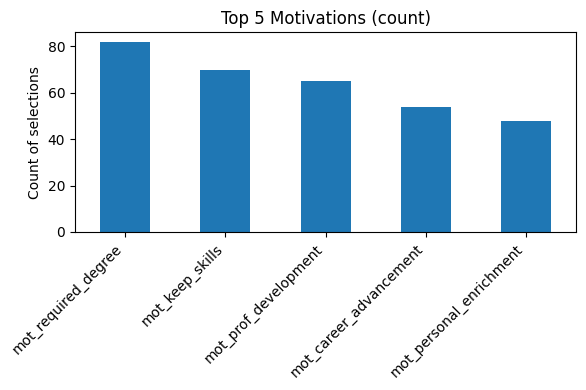

<Figure size 700x400 with 0 Axes>

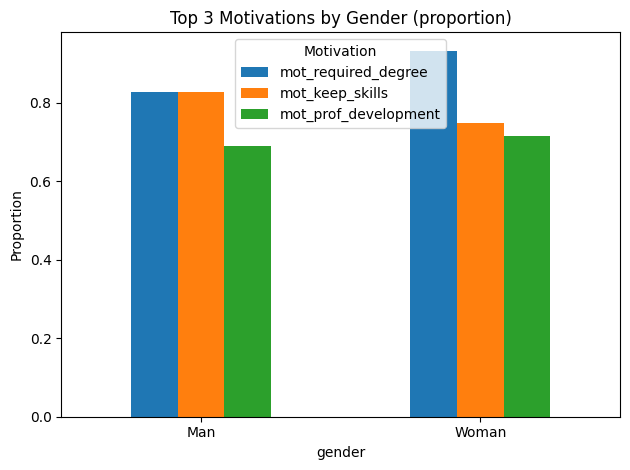

In [7]:
# Identify motivation columns
mot_cols = sorted([c for c in df.columns if c.startswith('mot_')])
print("Motivation columns:", mot_cols)

# Overall counts/proportions
mot_counts = df[mot_cols].sum().sort_values(ascending=False)
mot_props = df[mot_cols].mean().sort_values(ascending=False)
mot_summary = pd.DataFrame({'count':mot_counts, 'proportion':mot_props})
display(mot_summary)

# By gender
gender_mot = df.groupby('gender')[mot_cols].mean()
print("By gender (proportion):")
display(gender_mot)

# By age
age_mot = df.groupby('age')[mot_cols].mean()
print("By age (proportion):")
display(age_mot)

# Visualization
import matplotlib.pyplot as plt
top5 = mot_counts.head(5).index.tolist()
plt.figure(figsize=(6,4))
mot_summary.loc[top5,'count'].plot(kind='bar')
plt.title('Top 5 Motivations (count)')
plt.ylabel('Count of selections')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Top 3 motivations proportion by gender
plt.figure(figsize=(7,4))
gender_mot.loc[['Man','Woman'], top5[:3]].plot(kind='bar')
plt.title('Top 3 Motivations by Gender (proportion)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Motivation')
plt.tight_layout()
plt.show()

## Question 2: Information Sources Reach

We compute how many students heard about the course from each source to assess reach.

Source columns: ['src_ccm_admissions', 'src_ccm_advisor_counselor', 'src_ccm_it_website', 'src_employer', 'src_high_school_counselor', 'src_other']


,count,proportion
src_ccm_advisor_counselor,33,0.358696
src_ccm_admissions,25,0.271739
src_ccm_it_website,18,0.195652
src_high_school_counselor,10,0.108696
src_employer,7,0.076087
src_other,5,0.054348


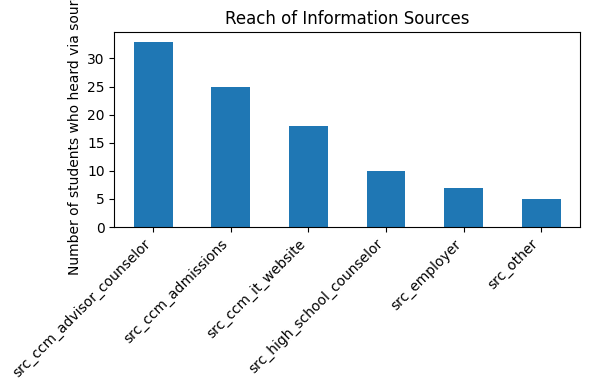

In [8]:
src_cols = sorted([c for c in df.columns if c.startswith('src_')])
print("Source columns:", src_cols)
src_summary = pd.DataFrame({
    'count': df[src_cols].sum(),
    'proportion': df[src_cols].mean()
}).sort_values('count', ascending=False)
display(src_summary)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
src_summary['count'].plot(kind='bar')
plt.title('Reach of Information Sources')
plt.ylabel('Number of students who heard via source')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Question 3: Source vs Interest in Further Computing Classes

We compare average interest scores (1–5) of students grouped by how they heard about the course.

,source,mean_interest,median_interest,count
5,src_other,3.000000,3.0,5
3,src_employer,3.000000,3.0,7
0,src_ccm_admissions,2.920000,3.0,25
1,src_ccm_advisor_counselor,2.787879,3.0,33
4,src_high_school_counselor,2.700000,3.0,10
2,src_ccm_it_website,2.555556,2.5,18


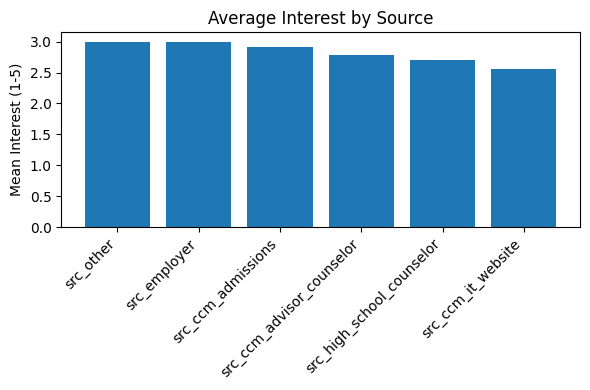

/tmp/ipython-input-3622594750.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[src])


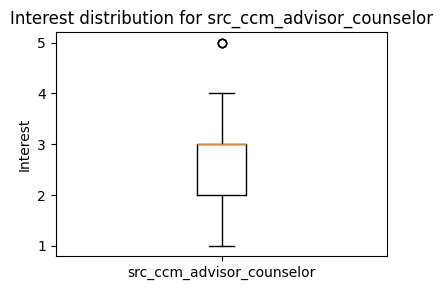

/tmp/ipython-input-3622594750.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[src])


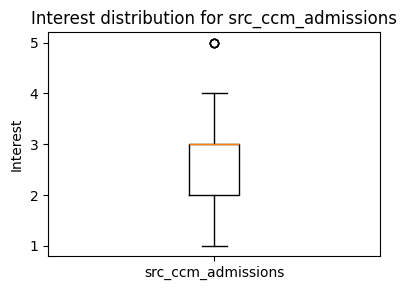

/tmp/ipython-input-3622594750.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=[src])


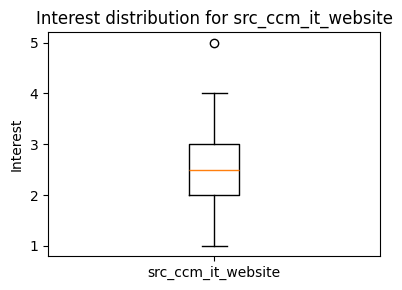

In [9]:
# Compute mean interest by source (require minimum sample size)
interest_by_source = []
for src in src_cols:
    subset = df[df[src]==1]['interest_overall'].dropna()
    if len(subset) >= 5:
        interest_by_source.append({
            'source': src,
            'mean_interest': subset.mean(),
            'median_interest': subset.median(),
            'count': len(subset)
        })
interest_df = pd.DataFrame(interest_by_source).sort_values('mean_interest', ascending=False)
display(interest_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.bar(interest_df['source'], interest_df['mean_interest'])
plt.title('Average Interest by Source')
plt.ylabel('Mean Interest (1-5)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplots for top 3 by count
top3 = interest_df.sort_values('count', ascending=False).head(3)['source'].tolist()
for src in top3:
    data = df[df[src]==1]['interest_overall'].dropna()
    plt.figure(figsize=(4,3))
    plt.boxplot(data, labels=[src])
    plt.title(f'Interest distribution for {src}')
    plt.ylabel('Interest')
    plt.tight_layout()
    plt.show()

## Question 4: Computing Class Interests by Race/Ethnicity

We evaluate which specific computing areas students are interested in and examine differences across race/ethnicity.

Interest type columns: ['int_app_dev', 'int_cybersecurity', 'int_data_analytics', 'int_game_design', 'int_hardware_repair', 'int_ml_ai', 'int_programming', 'int_web_dev']


,count,proportion
int_cybersecurity,31,0.336957
int_game_design,28,0.304348
int_ml_ai,28,0.304348
int_app_dev,24,0.260870
int_programming,22,0.239130
int_hardware_repair,22,0.239130
int_web_dev,22,0.239130
int_data_analytics,21,0.228261


Proportion of interest types by race/ethnicity:


,int_app_dev,int_cybersecurity,int_data_analytics,int_game_design,int_hardware_repair,int_ml_ai,int_programming,int_web_dev
race_ethnicity,,,,,,,,
American Indian/Native American/Alaska Native;White/Caucasian,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
Asian,0.666667,0.333333,0.000000,0.333333,0.333333,0.666667,0.666667,0.333333
Asian;Black/African American,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
Asian;White/Caucasian,0.333333,0.333333,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333
Black/African American,0.666667,0.500000,0.166667,0.500000,0.166667,0.333333,0.500000,0.333333
Choose not to reply,0.400000,0.400000,0.600000,0.400000,0.600000,0.600000,0.600000,0.400000
Hispanic or Latino,0.307692,0.423077,0.346154,0.269231,0.230769,0.461538,0.307692,0.346154
Hispanic or Latino;Asian;White/Caucasian,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
Hispanic or Latino;Black/African American,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


/tmp/ipython-input-4103943740.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


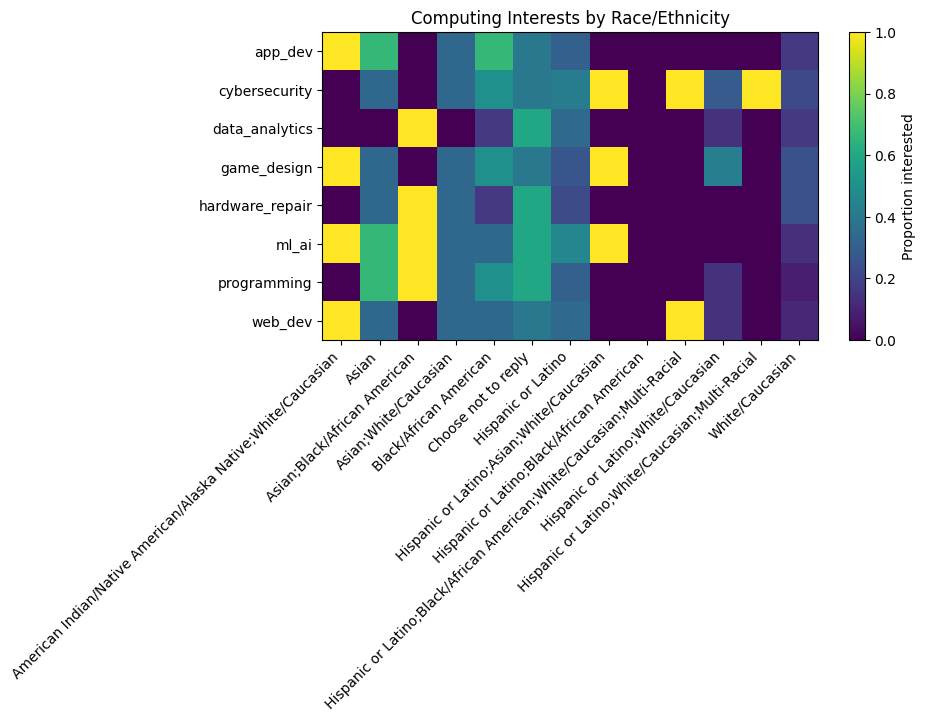

In [10]:
int_cols = sorted([c for c in df.columns if c.startswith('int_')])
print("Interest type columns:", int_cols)

# Overall interest counts
int_summary = pd.DataFrame({
    'count': df[int_cols].sum(),
    'proportion': df[int_cols].mean()
}).sort_values('count', ascending=False)
display(int_summary)

# Proportion by race/ethnicity
df['race_ethnicity'] = df['race_ethnicity'].fillna('Unknown')
interest_by_race = df.groupby('race_ethnicity')[int_cols].mean()
print("Proportion of interest types by race/ethnicity:")
display(interest_by_race)

# Heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.imshow(interest_by_race.T, aspect='auto')
plt.yticks(range(len(int_cols)), [c.replace('int_','') for c in int_cols])
plt.xticks(range(len(interest_by_race.index)), interest_by_race.index, rotation=45, ha='right')
plt.colorbar(label='Proportion interested')
plt.title('Computing Interests by Race/Ethnicity')
plt.tight_layout()
plt.show()

## Summary

Write-up suggestions (fill in after reviewing the outputs):
- Top motivations overall and which demographics emphasize different ones.  
- Which sources have the biggest reach, and whether some sources correlate with higher expressed interest in further computing classes.  
- Which computing subject interests are most common, and any observed variations across race/ethnicity groups.